## CNN-LSTM IoMT IDS
### CSCI 6505 Group Project
### Author: Hongwei Zhang & Koil Jat Chong
### Enhancing Intrusion Detection in Healthcare IoMT Devices Using the CNN-LSTM Model

### Preprocessing of [CIC IoMT dataset 2024](https://www.unb.ca/cic/datasets/iomt-dataset-2024.html)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import os
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.simplefilter('ignore')

In [2]:
# Read the dataset files list
file_list = pd.read_csv('./dataset/file_list.csv')
file_list.head()

,File,Category,Attack,Class
0,ARP_Spoofing_train.pcap.csv,SPOOFING,ARP Spoofing,1
1,Benign_train.pcap.csv,BENIGN,Benign,0
2,MQTT-DDoS-Connect_Flood_train.pcap.csv,MQTT,DDoS Connect Flood,1
3,MQTT-DDoS-Publish_Flood_train.pcap.csv,MQTT,DDoS Publish Flood,1
4,MQTT-DoS-Connect_Flood_train.pcap.csv,MQTT,DoS Connect Flood,1


In [3]:
# Import the dataset
data_dir = "./dataset/"
first_file_path = os.path.join(data_dir, file_list.iloc[0]['File'])
column_names = pd.read_csv(first_file_path, nrows=0).columns.tolist()

datasets_list = [] 
for _, row in file_list.iterrows():
    file_path = os.path.join(data_dir, row['File'])
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, header=None, skiprows=1, names=column_names)
        data['Category'] = row['Category']
        data['Attack'] = row['Attack']
        data['Class'] = row['Class']
        datasets_list.append(data)
    else:
        print(f"File not found: {file_path}")

# Combine all datasets into a single DataFrame
dataset = pd.concat(datasets_list, ignore_index=True)
dataset

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category,Attack,Class
0,866.600000,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,5.500000,16.963645,213.095221,66236.076476,0.900000,38.500000,SPOOFING,ARP Spoofing,1
1,3934.300000,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,13.500000,30.885371,708.919620,251721.126817,1.000000,244.600000,SPOOFING,ARP Spoofing,1
2,5592.800000,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,1.361110e-02,5.500000,21.787095,290.694475,84028.647525,0.900000,38.500000,SPOOFING,ARP Spoofing,1
3,9303.600000,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,1.694026e+08,13.500000,26.954506,597.046005,178453.001691,1.000000,244.600000,SPOOFING,ARP Spoofing,1
4,8592.400000,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,1.393099e-02,5.500000,24.255148,375.324132,80115.110731,0.900000,38.500000,SPOOFING,ARP Spoofing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160826,13234.910000,17.0,64.0,29460.045053,29460.045053,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.164175,8.453393,279.410488,0.130000,141.550000,DoS,DoS UDP,1
7160827,18136.530000,17.0,64.0,29318.535060,29318.535060,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.060924,3.012129,35.475423,0.130000,141.550000,DoS,DoS UDP,1
7160828,23038.040000,17.0,64.0,29363.556139,29363.556139,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.075262,3.287396,34.963050,0.160000,141.550000,DoS,DoS UDP,1
7160829,58526.160000,17.0,64.0,26168.955034,26168.955034,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,18.631072,205.641671,70932.249555,0.350000,141.550000,DoS,DoS UDP,1


In [4]:
dataset[dataset['Class'] == 0].head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category,Attack,Class
16047,134.3,7.1,64.0,40415.288318,40415.288318,0.0,0.0,0.0,0.0,0.5,...,1.694641e+08,5.5,15.312231,68.201654,2644.242675,0.9,38.5,BENIGN,Benign,0
16048,137.0,4.7,49.9,58749.191833,58749.191833,0.0,0.0,0.0,0.0,0.2,...,1.694641e+08,13.5,13.468364,84.997147,5328.483794,1.0,244.6,BENIGN,Benign,0
16049,283.9,6.0,64.0,3.497439,3.497439,0.0,0.0,0.0,0.0,0.5,...,8.070469e-05,5.5,12.229315,14.458481,124.725884,0.9,38.5,BENIGN,Benign,0
16050,297.3,6.0,64.0,7297.703020,7297.703020,0.0,0.0,0.0,0.0,0.5,...,1.694641e+08,13.5,12.552920,21.904691,240.536207,1.0,244.6,BENIGN,Benign,0
16051,572.3,7.1,57.7,2.549120,2.549120,0.0,0.0,0.0,0.0,0.4,...,9.993820e-02,5.5,13.928729,98.625651,11737.768847,0.9,38.5,BENIGN,Benign,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160831 entries, 0 to 7160830
Data columns (total 48 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float64
 1   Protocol Type    float64
 2   Duration         float64
 3   Rate             float64
 4   Srate            float64
 5   Drate            float64
 6   fin_flag_number  float64
 7   syn_flag_number  float64
 8   rst_flag_number  float64
 9   psh_flag_number  float64
 10  ack_flag_number  float64
 11  ece_flag_number  float64
 12  cwr_flag_number  float64
 13  ack_count        float64
 14  syn_count        float64
 15  fin_count        float64
 16  rst_count        float64
 17  HTTP             float64
 18  HTTPS            float64
 19  DNS              float64
 20  Telnet           float64
 21  SMTP             float64
 22  SSH              float64
 23  IRC              float64
 24  TCP              float64
 25  UDP              float64
 26  DHCP             float64
 27  ARP         

In [6]:
dataset.describe()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
count,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7160831.0,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,...,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06
mean,2.958836e+04,8.042957e+00,6.474653e+01,1.523202e+04,1.523202e+04,0.0,5.079549e-03,1.587609e-01,3.862139e-02,2.240655e-02,...,6.405743e+00,6.084036e+01,8.468349e+07,9.499081e+00,1.045008e+01,9.047367e+00,2.535226e+03,9.148464e-02,1.415273e+02,9.730852e-01
std,2.762618e+05,6.292201e+00,8.405262e+00,3.950968e+04,3.950968e+04,0.0,3.411170e-02,3.388233e-01,1.371016e-01,9.713147e-02,...,3.917360e+01,8.787628e+01,1.788442e+07,8.446717e-01,3.169197e+00,5.538149e+01,2.045832e+04,2.327133e-01,2.174138e+01,1.618343e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.200000e+01,-1.282061e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.400000e+01,1.160000e+00,6.400000e+01,6.685014e+00,6.685014e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.258000e+01,8.467888e+07,9.500000e+00,9.199377e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
50%,1.080000e+02,6.000000e+00,6.400000e+01,1.452887e+02,1.452887e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.000000e+01,8.469641e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
75%,1.958050e+04,1.700000e+01,6.400000e+01,1.914681e+04,1.914681e+04,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.400000e+01,8.469686e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
max,9.895636e+06,1.700000e+01,2.550000e+02,2.097152e+06,2.097152e+06,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,7.211509e+02,1.514000e+03,1.694694e+08,1.500000e+01,5.502727e+01,1.020232e+03,5.204379e+05,1.000000e+00,2.446000e+02,1.000000e+00


In [7]:
# Function to create barplot
def barplot_show(data, column, width=8):
    plt.figure(figsize=(width, 6))
    barplot = sb.barplot(
        y=data[column].value_counts().values, 
        x=data[column].value_counts().index, 
        palette="Spectral")
    barplot.set(xlabel=column, ylabel='Number of Samples')
    for p in barplot.patches:
        barplot.annotate(format(int(p.get_height()), 'd'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.show()

In [8]:
dataset['Category'].value_counts()

Category
DDoS        4779859
DoS         1805529
MQTT         262938
BENIGN       192732
RECON        103726
SPOOFING      16047
Name: count, dtype: int64

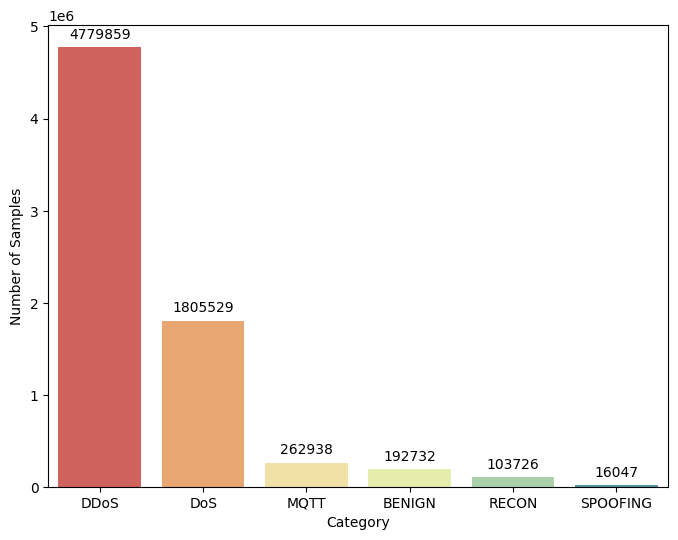

In [9]:
barplot_show(dataset, 'Category')

In [10]:
dataset['Attack'].value_counts()

Attack
DDoS UDP              1635956
DDoS ICMP             1537476
DDoS TCP               804465
DDoS SYN               801962
DoS UDP                566950
DoS SYN                441903
DoS ICMP               416292
DoS TCP                380384
Benign                 192732
DDoS Connect Flood     173036
Port Scan               83981
DoS Publish Flood       44376
DDoS Publish Flood      27623
OS Scan                 16832
ARP Spoofing            16047
DoS Connect Flood       12773
Malformed Data           5130
VulScan                  2173
Ping Sweep                740
Name: count, dtype: int64

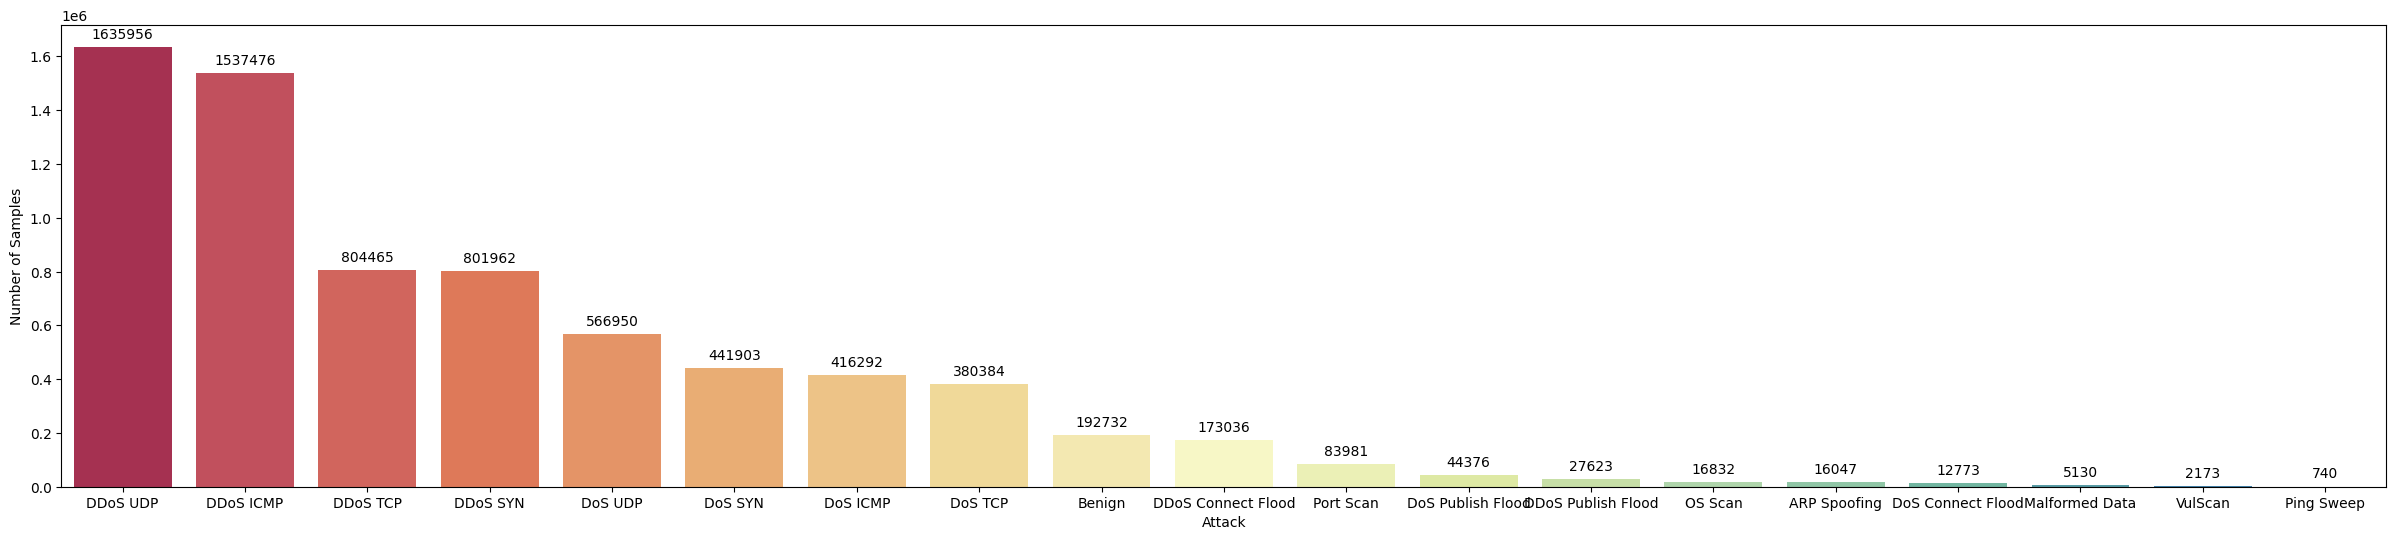

In [11]:
barplot_show(dataset, 'Attack', width=30)

In [12]:
dataset['Class'].value_counts()

Class
1    6968099
0     192732
Name: count, dtype: int64

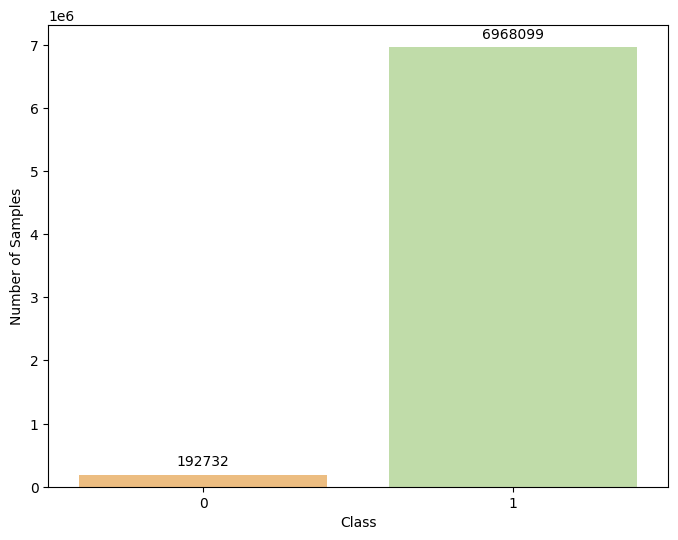

In [13]:
barplot_show(dataset, 'Class', width=8)

In [14]:
# Select 'Category' to perform multiclass classification
selected_data = dataset.iloc[:, :46]
selected_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category
0,866.6,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,150.681076,431.8,1.694026e+08,5.5,16.963645,213.095221,66236.076476,0.9,38.5,SPOOFING
1,3934.3,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,500.702909,406.3,1.694026e+08,13.5,30.885371,708.919620,251721.126817,1.0,244.6,SPOOFING
2,5592.8,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,205.552035,386.6,1.361110e-02,5.5,21.787095,290.694475,84028.647525,0.9,38.5,SPOOFING
3,9303.6,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,421.683660,300.2,1.694026e+08,13.5,26.954506,597.046005,178453.001691,1.0,244.6,SPOOFING
4,8592.4,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,265.394239,209.2,1.393099e-02,5.5,24.255148,375.324132,80115.110731,0.9,38.5,SPOOFING


In [15]:
# Random under sampling
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(selected_data.iloc[:, :-1], selected_data.iloc[:, -1])
processed_data = pd.DataFrame(X)
processed_data['Target'] = y
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
206413,312752.4,6.0,64.0,1.186829,1.186829,0.0,0.0,0.0,0.0,0.5,...,8.762493,76.3,1.139879e-04,5.5,12.437588,12.392036,85.604202,0.9,38.5,BENIGN
51539,72684.1,7.1,89.0,1.134988,1.134988,0.0,0.0,0.0,0.0,0.4,...,22.823265,94.7,1.694646e+08,13.5,12.727688,32.420795,659.477921,1.0,244.6,BENIGN
135832,4831091.0,6.0,55.0,4066.829125,4066.829125,0.0,0.0,0.0,0.0,0.0,...,0.000000,1514.0,1.290083e-04,5.5,55.027266,0.000000,0.000000,0.0,38.5,BENIGN
55911,343451.0,6.0,64.0,1.447449,1.447449,0.0,0.0,0.0,0.0,0.5,...,211.868209,81.2,1.694648e+08,13.5,16.545547,300.246612,45402.585713,1.0,244.6,BENIGN
138958,157723.0,6.0,64.0,2.034402,2.034402,0.0,0.0,0.0,0.0,0.5,...,15.321018,75.3,1.694667e+08,13.5,12.616717,21.679270,235.620920,1.0,244.6,BENIGN


In [16]:
processed_data['Target'].value_counts()

Target
BENIGN      16047
DDoS        16047
DoS         16047
MQTT        16047
RECON       16047
SPOOFING    16047
Name: count, dtype: int64

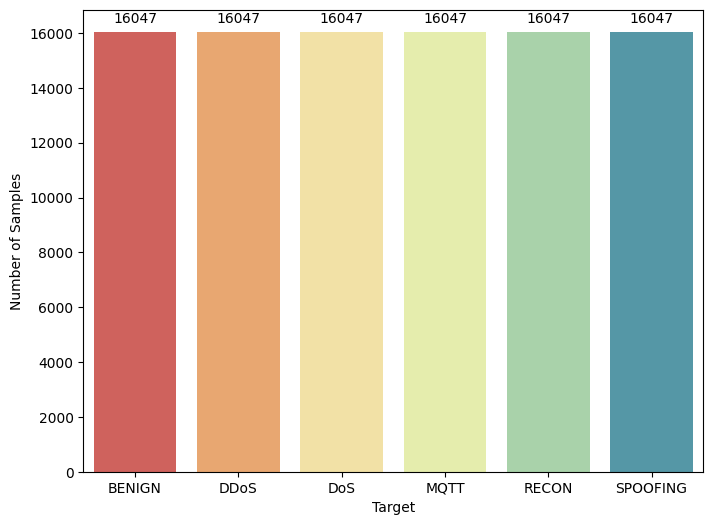

In [17]:
barplot_show(processed_data, 'Target')

In [18]:
# Encode the class labels
category_mapping = {
    'BENIGN': 0,
    'DDoS': 1,
    'DoS': 2,
    'MQTT': 3,
    'RECON': 4,
    'SPOOFING': 5
}
processed_data['Target'] = processed_data['Target'].map(category_mapping)
print(processed_data['Target'].unique())

[0 1 2 3 4 5]


In [19]:
# Normalize the data
scaler = MinMaxScaler()
normalize_data = processed_data.columns[:-1]
processed_data[normalize_data] = scaler.fit_transform(processed_data[normalize_data])
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
206413,0.031832,0.352941,0.250980,0.000001,0.000001,0.0,0.0,0.0,0.0,0.5,...,0.012176,0.023302,6.726164e-13,0.333333,0.071354,0.012167,0.000165,0.9,0.153941,0
51539,0.007398,0.417647,0.349020,0.000001,0.000001,0.0,0.0,0.0,0.0,0.4,...,0.031715,0.035802,9.999714e-01,0.925926,0.077679,0.031832,0.001271,1.0,1.000000,0
135832,0.491704,0.352941,0.215686,0.004293,0.004293,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,7.612482e-13,0.333333,1.000000,0.000000,0.000000,0.0,0.153941,0
55911,0.034956,0.352941,0.250980,0.000002,0.000002,0.0,0.0,0.0,0.0,0.5,...,0.294410,0.026630,9.999726e-01,0.925926,0.160926,0.294791,0.087534,1.0,1.000000,0
138958,0.016053,0.352941,0.250980,0.000002,0.000002,0.0,0.0,0.0,0.0,0.5,...,0.021290,0.022622,9.999838e-01,0.925926,0.075260,0.021285,0.000454,1.0,1.000000,0


In [20]:
# Shuffle the dataset
processed_data = processed_data.sample(frac=1).reset_index(drop=True)
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
0,0.000009,0.352941,0.25098,0.000013,0.000013,0.0,0.00,0.91,0.09,0.00,...,0.001031,0.009130,0.499774,0.629630,0.029902,0.001030,0.000003,0.43,0.57697,1
1,0.000017,0.352941,0.25098,0.000014,0.000014,0.0,0.00,0.00,1.00,0.00,...,0.000000,0.008152,0.499774,0.629630,0.026757,0.000000,0.000000,0.00,0.57697,1
2,0.000022,0.352941,0.25098,0.000034,0.000034,0.0,0.14,0.11,0.17,0.22,...,0.005121,0.016202,0.499601,0.629630,0.052762,0.005111,0.000035,0.89,0.57697,3
3,0.000005,0.352941,0.25098,0.000076,0.000076,0.0,0.00,0.00,1.00,0.00,...,0.000000,0.008152,0.999651,0.925926,0.026757,0.000000,0.000000,0.00,1.00000,4
4,0.009294,0.482353,0.25098,0.000004,0.000004,0.0,0.10,0.10,0.00,0.30,...,0.021150,0.023234,0.999955,0.925926,0.074661,0.021142,0.000448,1.00,1.00000,0


In [21]:
processed_data['Target'].value_counts()

Target
1    16047
3    16047
4    16047
0    16047
2    16047
5    16047
Name: count, dtype: int64

In [22]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96282 entries, 0 to 96281
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Header_Length    96282 non-null  float64
 1   Protocol Type    96282 non-null  float64
 2   Duration         96282 non-null  float64
 3   Rate             96282 non-null  float64
 4   Srate            96282 non-null  float64
 5   Drate            96282 non-null  float64
 6   fin_flag_number  96282 non-null  float64
 7   syn_flag_number  96282 non-null  float64
 8   rst_flag_number  96282 non-null  float64
 9   psh_flag_number  96282 non-null  float64
 10  ack_flag_number  96282 non-null  float64
 11  ece_flag_number  96282 non-null  float64
 12  cwr_flag_number  96282 non-null  float64
 13  ack_count        96282 non-null  float64
 14  syn_count        96282 non-null  float64
 15  fin_count        96282 non-null  float64
 16  rst_count        96282 non-null  float64
 17  HTTP        

In [23]:
processed_data.describe()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
count,96282.000000,96282.000000,96282.000000,96282.000000,96282.000000,96282.0,96282.000000,96282.000000,96282.00000,96282.000000,...,96282.000000,96282.000000,9.628200e+04,96282.000000,96282.000000,96282.000000,96282.000000,96282.000000,96282.000000,96282.000000
mean,0.051575,0.454669,0.269925,0.005972,0.005972,0.0,0.023500,0.158357,0.11062,0.143405,...,0.074064,0.086994,4.996776e-01,0.629478,0.130768,0.073935,0.039753,0.462075,0.576770,2.500000
std,0.147204,0.278238,0.115787,0.025496,0.025496,0.0,0.070236,0.321787,0.26421,0.213477,...,0.166115,0.206435,3.547112e-01,0.210321,0.221808,0.165990,0.118878,0.446190,0.300188,1.707834
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000011,0.352941,0.250980,0.000004,0.000004,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.008152,5.916096e-10,0.333333,0.026757,0.000000,0.000000,0.000000,0.153941,1.000000
50%,0.000510,0.352941,0.250980,0.000016,0.000016,0.0,0.000000,0.000000,0.00000,0.000000,...,0.003117,0.016073,4.996491e-01,0.629630,0.049967,0.002990,0.000024,0.400000,0.576970,2.500000
75%,0.011085,0.417647,0.250980,0.000163,0.000163,0.0,0.000000,0.110000,0.00000,0.270000,...,0.029165,0.032065,9.991383e-01,0.925926,0.091387,0.028699,0.001405,0.900000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [24]:
# Export the processed dataset
processed_data.to_csv("./dataset/processed_data.csv", index=False, header=True)

### Data Preprocessing Complete.

Addtional Processing with SMOTE

The current dataset appears to be heavily imbalanced, with greater proportion of Class 1 compared to Class 0 (Beneign Category). This imbalance can lead to biased model performance. To address this issue, we will use the Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset.

SMOTE is an oversampling technique that generates synthetic samples in the minority class. It works by selecting two or more similar instances (using a distance measure) and perturbing the instances one at a time by a random amount within the difference to create a new instance. This technique helps to balance the dataset and improve the model performance.



In [25]:
#!pip install imbalanced-learn

In [26]:
selected_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category
0,866.6,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,150.681076,431.8,1.694026e+08,5.5,16.963645,213.095221,66236.076476,0.9,38.5,SPOOFING
1,3934.3,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,500.702909,406.3,1.694026e+08,13.5,30.885371,708.919620,251721.126817,1.0,244.6,SPOOFING
2,5592.8,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,205.552035,386.6,1.361110e-02,5.5,21.787095,290.694475,84028.647525,0.9,38.5,SPOOFING
3,9303.6,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,421.683660,300.2,1.694026e+08,13.5,26.954506,597.046005,178453.001691,1.0,244.6,SPOOFING
4,8592.4,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,265.394239,209.2,1.393099e-02,5.5,24.255148,375.324132,80115.110731,0.9,38.5,SPOOFING


In [27]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X_original = selected_data.drop('Category', axis=1)
y_original = selected_data['Category']

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_original, y_original)

# Convert resampled data back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X_original.columns)
df_resampled['Category'] = y_resampled

# Save or inspect the augmented data
print("Original Data Distribution:")
print(y_original.value_counts())
print("\nResampled Data Distribution:")
print(df_resampled['Category'].value_counts())


In [ ]:
df_resampled['Category'] = df_resampled['Category'].map(category_mapping)


In [ ]:
normalize_data = df_resampled.columns[:-1]
df_resampled[normalize_data] = scaler.fit_transform(df_resampled[normalize_data])

In [ ]:
df_resampled.to_csv("./dataset/processed_data_SMOTE.csv", index=False, header=True)